### downlaod dataset

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

### Import module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import squarify
%matplotlib inline

### Take a look at data

In [2]:
# it takes a lot of time, maybe can teach read in chunks(?)
df = pd.read_excel( 'uci_online_retail_II.xlsx' )

In [3]:
df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [4]:
df.groupby(['Customer ID']).get_group(df.loc[0, 'Customer ID'])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


因為要分析的是每個客戶的價值，所以我們要大概知道一下總共有幾個客戶，這才是我們真實資料的大小

In [5]:
print('# of customer:', len( df['Customer ID'].unique() ) )

# of customer: 4384


### Preprocessing

得到消費的總金額 = 數量 x 單價

In [6]:
# Generate AMOUNT = P * Q
df['Amount'] = df['Quantity'] * df['Price']

In [7]:
# Separate date and time
df['Date'] = [d.date() for d in df['InvoiceDate']]
df['Time'] = [d.time() for d in df['InvoiceDate']]

這邊因為要算最近一次消費離"現在"多久，所以我們要定義"現在"：定義為所有資料中日期的後一日 + 1 天

In [8]:
# define the teminal day in the whole task
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

In [9]:
# drop NAs, transform ID into int
df_NoNA = df.dropna()
df_NoNA['Customer ID'] = df_NoNA['Customer ID'].map(int)

D:\python3.7\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


- recency: 最後一次消費離現在多久
- frequency: 消費的次數多少
- monetary: 消費的總金額是多少，順便看一下最大值、最小值、中位數

In [10]:
# Generate features
# Recency = days between last time buying and terminal day
# Frequency = how many times the consumer shopped
# Monetary = the total money the consumer shopped
data_process = df_NoNA.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'Amount': ['sum', 'max', 'min', 'median']
})

data_process.columns = ['Recency', 'Frequency', 'Monetary', 'Maximum', 'Minimum', 'Median']

In [11]:
data_process.head()

,Recency,Frequency,Monetary,Maximum,Minimum,Median
Customer ID,,,,,,
12346,67,46,-64.68,45.0,-142.31,7.49
12347,3,71,1323.32,70.8,7.80,15.00
12348,74,20,222.16,17.4,1.00,11.70
12349,43,107,2646.99,250.0,-14.95,17.00
12351,11,21,300.93,23.4,9.90,14.85


利用直方圖查看資料的分布

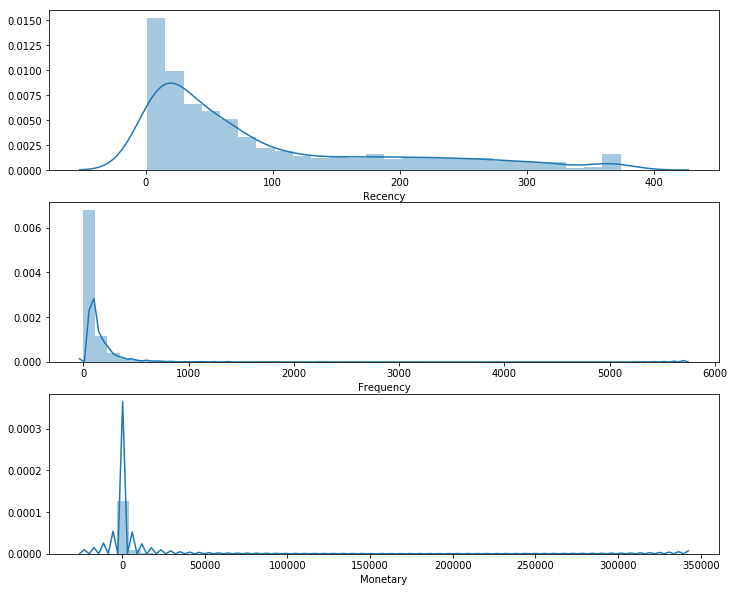

In [12]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['Monetary'])
plt.show()

### Rule-based RFM model

利用百分位數分出R、F、M三格維度中的四個級距

In [13]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)
# Create new columns R, F and M 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)
data_process.head()

,Recency,Frequency,Monetary,Maximum,Minimum,Median,R,F,M
Customer ID,,,,,,,,,
12346,67,46,-64.68,45.0,-142.31,7.49,2,3,1
12347,3,71,1323.32,70.8,7.80,15.00,4,3,3
12348,74,20,222.16,17.4,1.00,11.70,2,2,1
12349,43,107,2646.99,250.0,-14.95,17.00,3,4,4
12351,11,21,300.93,23.4,9.90,14.85,4,2,2


把編號代碼化，用以區分更細緻的組別

In [14]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,Maximum,Minimum,Median,R,F,M,RFM_Segment_Concat
Customer ID,,,,,,,,,,
12346,67,46,-64.68,45.0,-142.31,7.49,2,3,1,231
12347,3,71,1323.32,70.8,7.80,15.00,4,3,3,433
12348,74,20,222.16,17.4,1.00,11.70,2,2,1,221
12349,43,107,2646.99,250.0,-14.95,17.00,3,4,4,344
12351,11,21,300.93,23.4,9.90,14.85,4,2,2,422


In [24]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print('# of unique RFM groups:', rfm_count_unique.sum())

# of unique RFM groups: 61


計算RFM三個分數加總的總和，用以做比較大的分組

In [16]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm['RFM_Score'].head()

Customer ID
12346     6.0
12347    10.0
12348     5.0
12349    11.0
12351     8.0
Name: RFM_Score, dtype: float64

把總和分數的級距區分出來

In [17]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
    
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)

rfm.head() # don't use print cause the default output of pandas in jupyter is prettier

,Recency,Frequency,Monetary,Maximum,Minimum,Median,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
Customer ID,,,,,,,,,,,,
12346,67,46,-64.68,45.0,-142.31,7.49,2,3,1,231,6.0,Potential
12347,3,71,1323.32,70.8,7.80,15.00,4,3,3,433,10.0,Can't Loose Them
12348,74,20,222.16,17.4,1.00,11.70,2,2,1,221,5.0,Promising
12349,43,107,2646.99,250.0,-14.95,17.00,3,4,4,344,11.0,Can't Loose Them
12351,11,21,300.93,23.4,9.90,14.85,4,2,2,422,8.0,Champions


針對分數比較低的四個類別的解釋：
- Potential — high potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!
- Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.
- Needs Attention — made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
- Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

由於他們才是真的要考量投注廣告的族群，因此我們對這四個族群做深入的分析

reference: https://www.putler.com/rfm-analysis/

查看每個大分類的統計數值

In [18]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
rfm_level_agg

Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      27.7     199.3   4158.5  1700
Champions             58.9      57.9   1125.7   458
Loyal                 81.3      41.0    696.5   492
Needs Attention      176.3      15.2    190.4   401
Potential             93.5      28.4    488.6   459
Promising            144.9      21.6    322.8   458
Require Activation   256.9       7.3    -67.4   415

把結果畫出來看一下

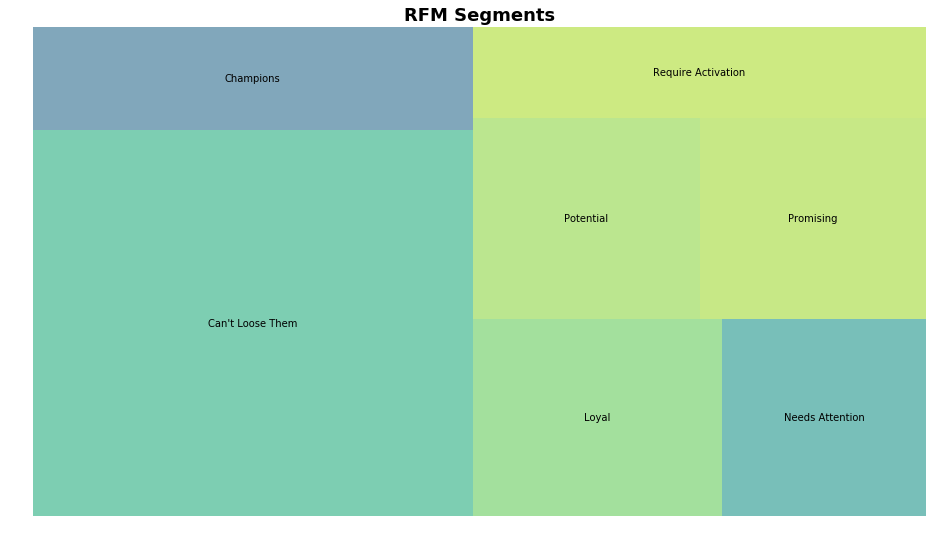

In [19]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

### Clustering

In [20]:
# since the data has skewness, we have to normalize it
rfm_normal = rfm.iloc[:,:3].copy()
rfm_mean = rfm_normal.mean()
rfm_std  = rfm_normal.std()
rfm_normal = ( rfm_normal - rfm_normal.mean() ) / rfm_normal.std()
# remove outliers
rfm_normal = rfm_normal[(rfm_normal < 3).all(axis=1)]

In [21]:
rfm_normal.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,-0.248483,-0.240416,-0.231163
12347,-0.900370,-0.118407,-0.068240
12348,-0.177183,-0.367305,-0.197493
12349,-0.492940,0.057285,0.087132
12351,-0.818884,-0.362424,-0.188247


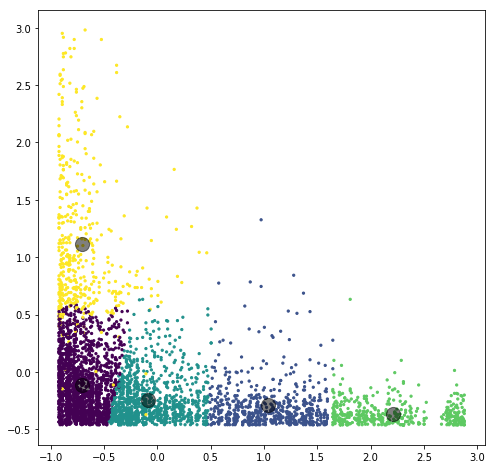

In [22]:
from sklearn.cluster import KMeans

X = rfm_normal.values
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

# using R, F to 2D-plot the result
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

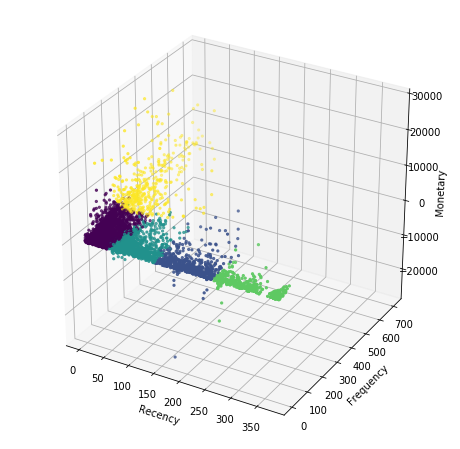

In [23]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

# plot the result
X_ori = ( rfm_normal * rfm_std + rfm_mean ).values
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(X_ori[:, 0], X_ori[:, 1], X_ori[:, 2], c=y_kmeans, s=5, cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# centers = kmeans.cluster_centers_
# print(centers)
# ax.scatter(centers[:, 0], centers[:, 1], centers[: 2], c='black', s=200, alpha=0.5)

plt.show()

### Reference
https://openresearch.lsbu.ac.uk/download/f25cea0577bb8f766859f86edc40145eb459118c5d54e0e9a2e20ed28e47b8dc/505906/20190518_DC_KG_BL.pdf

https://link.springer.com/article/10.1057/dbm.2012.17#Tab2

https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html